# Wind Turbine Fault Detection Study

## Introduction

The field of wind energy has witnessed substantial growth in recent years, with a focus on improving the efficiency and reliability of wind turbine (WT) systems. Fault detection and predictive maintenance have become crucial aspects in ensuring the optimal performance of these systems. In this study, we explore the WT-IIoT dataset made available through on **[Kaggle](https://www.kaggle.com/datasets/wasuratme96/iiot-data-of-wind-turbine)** and originating from the Microsoft Azure Predictive Maintenance Template. The dataset offers a unique opportunity to delve into the intricacies of fault classification based on Supervisory Control and Data Acquisition (SCADA) components, shedding light on potential improvements in predictive maintenance strategies for wind turbines.

## Dataset Overview

The dataset encompasses a range of SCADA measurments taken in the period April 2014-April 2015, providing a comprehensive view of the wind turbine's operational environment. The SCADA variables include essential parameters such as reactive power, blade angle, nacelle position, and temperatures of critical systems, including the bearing, rotor, and stator. Meteorological variables, though limited, encompass minimum, maximum, and average wind speeds. Additionally, the dataset contains status data, which are logs offering insights into the turbine's operating state through variables like main status, sub-status, full status, status Text, Service, FaultMsg.

## Dataset Features

* **Error':** Represents the occurrence of faults in the wind turbine system.

* **'WEC: ava. windspeed', 'WEC: max. windspeed', 'WEC: min. windspeed':** Meteorological variables indicating the availability, maximum, and minimum wind speeds.

* **'WEC: ava. Rotation', 'WEC: max. Rotation', 'WEC: min. Rotation':** Rotation-related variables providing information about the turbine's rotational behavior.

* **'WEC: ava. Power', 'WEC: max. Power', 'WEC: min. Power':** Power-related variables denoting the availability, maximum, and minimum power generated by the wind turbine.

* **'WEC: Operating Hours', 'WEC: Production kWh', 'WEC: Production minutes':** Variables offering insights into the turbine's operating hours and production metrics.

* **'WEC: ava. reactive Power', 'WEC: max. reactive Power', 'WEC: min. reactive Power':** Reactive power-related variables indicating availability, maximum, and minimum reactive power.

* **'WEC: ava. available P from wind', 'WEC: ava. available P technical reasons', 'WEC: ava. Available P force majeure reasons', 'WEC: ava. Available P force external reasons':** Variables categorizing available power based on various factors, such as wind, technical issues, force majeure, and external reasons.

* **'WEC: ava. blade angle A':** Availability of blade angle A, an essential parameter for turbine operation.

* **'Sys 1 inverter 1 cabinet temp.', 'Sys 1 inverter 2 cabinet temp.', ... 'Inverter std dev':** Various temperature-related variables, providing insights into the temperature distribution across different components of the wind turbine.

This study aims to harness these diverse features to develop a robust fault detection model to detect and classify the failures that can arise during wind turbine operation. Our data include the following failure types:

* **Feeding failure 'FF'**: which includes zero crossing in inverters, external shut down of inverters, inverters overload, load shedding in inverters.

* **Excitation failure 'EF'**: correspanding to Overvoltage in DC-link.

* **Main failure 'MF'**: which includes start delay, undervoltage in L1 or L2.

* **Air gap monitoring failure 'AF'**: triggered by sensor 1 in blade C.

* **Generator heating failure 'GF'**: which can happen in Hygrostat inverter or Hygrostat rectifier or Isometer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
ls ./wind_turbine/

fault_data.csv*  scada_data.csv*  status_data.csv*


In [3]:
fault_data = pd.read_csv("./wind_turbine/fault_data.csv", parse_dates=["DateTime"], index_col="DateTime")
scada_data = pd.read_csv("./wind_turbine/scada_data.csv", parse_dates=["DateTime"], index_col="DateTime")
status_data = pd.read_csv("./wind_turbine/status_data.csv", parse_dates=["Time"], dayfirst=True, index_col="Time")

In [4]:
fault_data.head()

,Time,Fault
DateTime,,
2014-05-14 14:39:44,1.400096e+09,GF
2014-05-14 14:50:24,1.400097e+09,GF
2014-05-14 14:58:56,1.400098e+09,GF
2014-05-14 15:09:36,1.400098e+09,GF
2014-05-14 15:20:16,1.400099e+09,GF


In [5]:
scada_data.head()

,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
DateTime,,,,,,,,,,,,,,,,,,,,,
2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.0,0.02,0.0,0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.0,0.01,0.0,0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.0,0.04,0.0,0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.0,0.08,0.0,0,0,...,23,21,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.0,0.05,0.0,0,0,...,23,21,25,12,14,23,34,2501,25.272728,1.103713


In [6]:
status_data.head()

,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
Time,,,,,,,,
2014-04-24 12:37:38,0,0,0 : 0,Turbine in operation,1,False,False,7.4
2014-04-25 19:27:24,71,104,71 : 104,Insulation monitoring : Insulation fault Phase U2,6,False,True,20.5
2014-04-26 09:30:13,8,0,8 : 0,Maintenance,6,True,False,17.1
2014-04-26 10:05:19,8,0,8 : 0,Maintenance,6,False,False,8.7
2014-04-26 10:05:25,8,0,8 : 0,Maintenance,6,True,False,10.6


In [7]:
# check datasets sizes
print("Fault data shape:", fault_data.shape)
print("SCADA data shape:", scada_data.shape)
print("Status data shape:", status_data.shape)

Fault data shape: (553, 2)
SCADA data shape: (49027, 65)
Status data shape: (1849, 8)


#### Observation

The fault and status data contains less samples than the total SCADA data because they only include timestamps when a failure actually occured in the wind turbine, so we need to consider that we combining the fault features into the SCADA data.

In [8]:
# check for missing instances
print(f"Fault data missing instances count: {(fault_data.isna().sum()).sum()}")
print(f"SCADA data missing instances count: {(scada_data.isna().sum()).sum()}")
print(f"Status data missing instances count: {(status_data.isna().sum()).sum()}")

Fault data missing instances count: 0
SCADA data missing instances count: 0
Status data missing instances count: 0


In [9]:
# check datasets datetime ranges
print(f"Fault data datetime range from {fault_data.index[0]} to {fault_data.index[-1]}")
print(f"SCADA data datetime range from {scada_data.index[0]} to {scada_data.index[-1]}")
print(f"Status data datetime range from {status_data.index[0]} to {status_data.index[-1]}")

Fault data datetime range from 2014-05-14 14:39:44 to 2015-01-15 23:09:20
SCADA data datetime range from 2014-05-01 00:00:00 to 2015-04-09 00:00:00
Status data datetime range from 2014-04-24 12:37:38 to 2015-04-28 22:18:19


#### Observation

The status data is recorded on a larger datetime range compared to the SCADA data, so to combine the status values with the scada and fault datasets we will be forced to drop some of the additional status record that aren't presents in the two other datasets and thus our study datetime range will be from 2014-05-01 00:00:00 to 2015-04-09 00:00:00.

In [10]:
from datetime import datetime

print("Fault data date/time from DateTime:", fault_data.index[0])
print("Fault data date/time from Timestamp:", datetime.fromtimestamp(fault_data["Time"][0]))

Fault data date/time from DateTime: 2014-05-14 14:39:44
Fault data date/time from Timestamp: 2014-05-14 20:39:44


#### Observation

In both the fault and SCADA datasets it seems that the recorded datetime values are lagging 6 hours behind the recorded timestamp, and the status data contains the lagging datetime values. Because the timestamps records seems more accurate between the fault and SCADA datasets will using them as indexes, and we will have to change the status data timestamps later on.

In [11]:
# change the indexes using "TIME" timestamps
# convert to readable datetimes
fault_data.index = fault_data.Time.apply(lambda x: datetime.fromtimestamp(x))
fault_data = fault_data.drop(["Time"], axis=1)

scada_data.index = scada_data.Time.apply(lambda x: datetime.fromtimestamp(x))
scada_data = scada_data.drop(["Time"], axis=1)

In [12]:
# Check if there are missing values
print("Missing values in Fault data:", (fault_data.isna().sum()).sum())
print("Missing values in SCADA data:", (scada_data.isna().sum()).sum())
print("Missing values in Status data:", (status_data.isna().sum()).sum())

Missing values in Fault data: 0
Missing values in SCADA data: 0
Missing values in Status data: 0


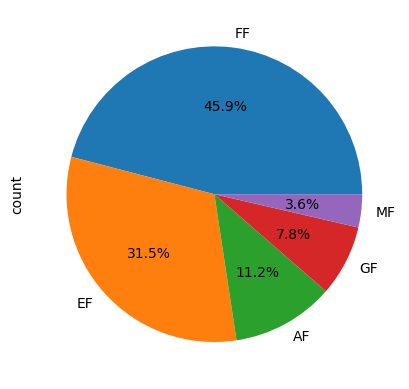

In [13]:
# Check fault classes distribution
_ = fault_data["Fault"].value_counts().plot(kind="pie", autopct='%1.1f%%')

#### Observation

Our data reveals five fault types, with "EF" and "FF" being more prevalent. This suggests that these fault types are likely the most frequently occurring in wind turbines. On the other hand, "MF," "GF," and "AF" faults are less prominent, indicating they may be rare or associated with critical failures in wind turbines, occurring only in extreme situations.

In [14]:
#Check for duplicated datetimes
print("Duplicated datetimes in Fault data:", (fault_data.index.duplicated()).sum())
print("Duplicated datetimes in SCADA data:", (scada_data.index.duplicated()).sum())
print("Duplicated datetimes in Status data:", (status_data.index.duplicated()).sum())

Duplicated datetimes in Fault data: 107
Duplicated datetimes in SCADA data: 6
Duplicated datetimes in Status data: 34


#### Observation

We observe duplicates in all our datasets, but it's important to note that they carry different significance. In the SCADA data, duplicated records can be easily eliminated. However, in the status and fault data, duplicated datetime records indicate instances when two or more fault types occur simultaneously in the wind turbine. These occurrences are crucial for our study.

To address datetime instances with multiple fault types, we will implement one-hot encoding for each fault type at a given datetime.

In [15]:
# drop duplicated instances in SCADA data
scada_data = scada_data[~scada_data.index.duplicated()]

### Check multiple faults occurances

In [16]:
faults = fault_data.groupby(fault_data.index)['Fault'].apply(lambda x: ','.join(x.astype(str)))
fault_classes = faults.str.get_dummies(sep=',')
fault_classes.set_index(faults.index)
fault_classes.head()

,AF,EF,FF,GF,MF
Time,,,,,
2014-05-14 20:39:44,0,0,0,1,0
2014-05-14 20:50:24,0,0,0,1,0
2014-05-14 20:58:56,0,0,0,1,0
2014-05-14 21:09:36,0,0,0,1,0
2014-05-14 21:20:16,0,0,0,1,0


In [17]:
# check which fault can occurs at the same time
fault_classes.apply(lambda x: f'{x["AF"]}{x["EF"]}{x["FF"]}{x["GF"]}{x["MF"]}', axis=1).value_counts()

00100    159
01100     95
01000     79
10000     50
00010     43
10001     12
00001      8
Name: count, dtype: int64

#### Observation

We observe occurrences where both "EF" and "FF" faults happen simultaneously in the wind turbine, as well as instances when "AF" and "MF" faults can occur simultaneously.

In [18]:
# we consider that all instances not present in fault are normal working conditions (No fault)
fault_column = fault_data[~fault_data.index.duplicated()].reindex(scada_data.index, fill_value="NF")

In [19]:
fault_column["Fault"].value_counts()

Fault
NF    48575
EF      174
FF      159
AF       62
GF       43
MF        8
Name: count, dtype: int64

#### Observation

We see now that the fault classes are highly imbalanced as the non fault class represent 99% of the data, seo for performing a classification task we will have to take a smaller sample for the non fault class and we need to use some rebalancing technique to add failure instances. We also notice that there is only 8 instances of MF fault which will give us problems when trying to train our models.

### Fault logs from status data

The status data contains the logs recorded during the wind turbine operations which inlude both normal working condition and when a failure occurs, we could considere adding those logs features to our global dataset but for the moment we will only work with fault and SCADA data.

## Exploratory data analysis

In [20]:
# combine fault data with scada data
combined_data = scada_data.merge(fault_column, on="Time", how="left")

In [21]:
combined_data.columns

Index(['Error', 'WEC: ava. windspeed', 'WEC: max. windspeed',
       'WEC: min. windspeed', 'WEC: ava. Rotation', 'WEC: max. Rotation',
       'WEC: min. Rotation', 'WEC: ava. Power', 'WEC: max. Power',
       'WEC: min. Power', 'WEC: ava. Nacel position including cable twisting',
       'WEC: Operating Hours', 'WEC: Production kWh',
       'WEC: Production minutes', 'WEC: ava. reactive Power',
       'WEC: max. reactive Power', 'WEC: min. reactive Power',
       'WEC: ava. available P from wind',
       'WEC: ava. available P technical reasons',
       'WEC: ava. Available P force majeure reasons',
       'WEC: ava. Available P force external reasons',
       'WEC: ava. blade angle A', 'Sys 1 inverter 1 cabinet temp.',
       'Sys 1 inverter 2 cabinet temp.', 'Sys 1 inverter 3 cabinet temp.',
       'Sys 1 inverter 4 cabinet temp.', 'Sys 1 inverter 5 cabinet temp.',
       'Sys 1 inverter 6 cabinet temp.', 'Sys 1 inverter 7 cabinet temp.',
       'Sys 2 inverter 1 cabinet temp.', 'Sys

In [22]:
# rename columns
combined_data.columns = ['Error', 'avg_ws', 'max_ws', 'min_ws', 'avg_rot', 'max_rot','min_rot',
                         'avg_power', 'max_power', 'min_power', 'avg_Nacel_position', 'Operating Hours',
                         'Production(kWh)', 'Production(min)', 'avg_reactive_power', 'max_reactive_power',
                         'min_reactive_power', 'avg_available_power_fw', 'avg_available_power_tr',
                         'avg_available_power_mr', 'avg_available_power_er', 'avg_blade_angle_A',
                         'temp_inverter11', 'temp_inverter12', 'temp_inverter13', 'temp_inverter14',
                         'temp_inverter15', 'temp_inverter16', 'temp_inverter17', 'temp_inverter21',
                         'temp_inverter22', 'temp_inverter23', 'temp_inverter24', 'temp_inverter25',
                         'temp_inverter26', 'temp_inverter27', 'temp_Spinner','temp_Front_bearing',
                         'temp_Rear_bearing', 'temp_Pitch_cabinet_blade_A', 'temp_Pitch_cabinet_blade_B',
                         'temp_Pitch_cabinet_blade_C', 'temp_Blade_A', 'temp_Blade_B', 'temp_Blade_C',
                         'temp_Rotor1', 'temp_Rotor2', 'temp_stator1', 'temp_stator2', 'temp_nacelle_ambient1',
                         'temp_nacelle_ambient2','temp_nacelle', 'temp_nacelle_cabinet', 'temp_main_carrier',
                         'temp_rectifier_cabinet', 'temp_yaw_inverter_cabinet', 'temp_fan_inverter_cabinet',
                         'temp_ambient', 'temp_tower', 'temp_control_cabinet', 'temp_Transformer', 'avg_RTU_setpoint1',
                         'Inverter averages', 'Inverter std dev', 'Fault']

In [23]:
# chech the Error column
combined_data["Error"].value_counts()

Error
0      48722
246      164
10        35
20        18
50        18
90        14
30        13
80         9
70         9
40         9
60         9
100        1
Name: count, dtype: int64

It seems that the Error column also indicates the type of fault that occures in the wind turbine, similair to the classes we've extracted above, so for a classification problem we must remove this column before training the models.

### Power/windspeed/rotation relationship

In [24]:
ws_rot_power_features = combined_data[['avg_ws', 'max_ws', 'min_ws', 'avg_rot', 'max_rot','min_rot',
                         'avg_power', 'max_power', 'min_power', 'avg_reactive_power', 'max_reactive_power',
                         'min_reactive_power']]

<Axes: xlabel='Time'>

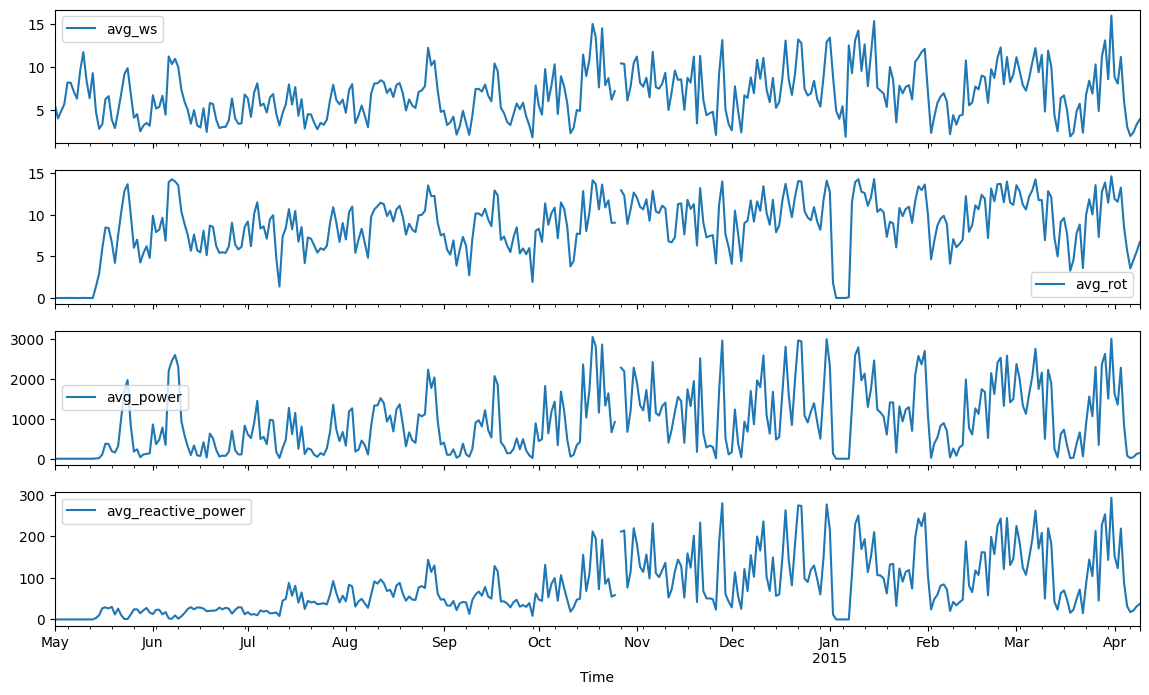

In [25]:
# plot average power, windspeed, rotation
fig, axs = plt.subplots(4, 1, sharex='col', figsize=(14, 8))
ws_rot_power_features.resample('D').mean().plot(y="avg_ws", ax=axs[0])
ws_rot_power_features.resample('D').mean().plot(y="avg_rot", ax=axs[1])
ws_rot_power_features.resample('D').mean().plot(y="avg_power", ax=axs[2])
ws_rot_power_features.resample('D').mean().plot(y="avg_reactive_power", ax=axs[3])

The power generated in a wind turbine is influenced by the rotation speed of its blades, which, in turn, is influenced by the wind speed. This correlation is clearly demonstrated, as the average power, reactive power, blade rotation, and wind speed exhibit synchronous variations.

<Axes: >

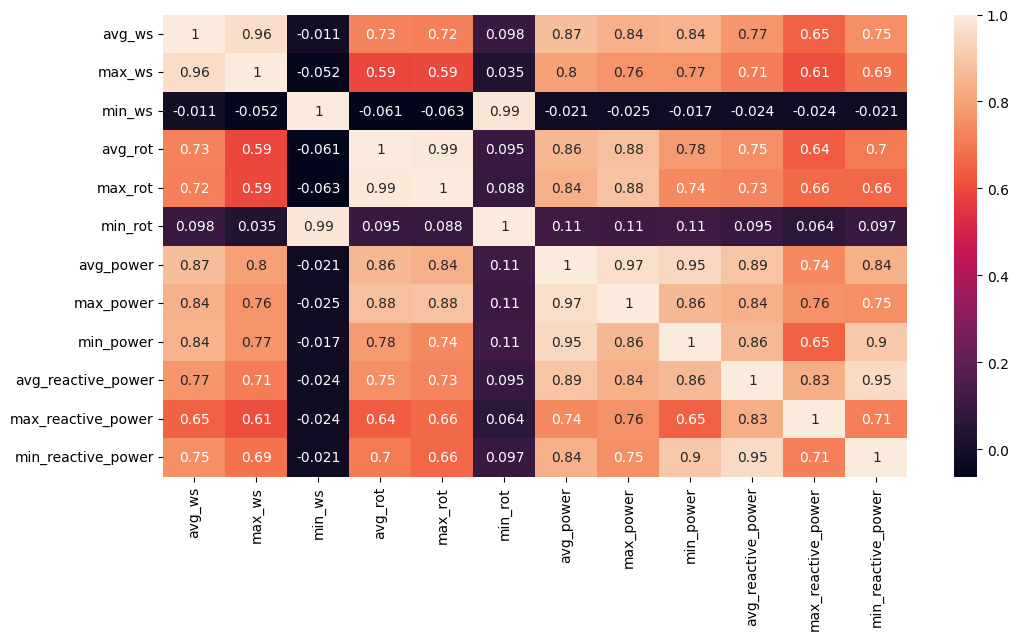

In [26]:
plt.figure(figsize=(12, 6))
sns.heatmap(ws_rot_power_features.corr(), annot=True)

The correlation matrix validates the earlier observation, indicating strong correlations (>60%) among average power, reactive power, blade rotation, and wind speed. Additionally, redundancy is observed in the max measurements, with correlations surpassing 90% when compared to the average measurements, those features should be removed before training the models to optimize the performance.

### Energy production

<Axes: xlabel='Time'>

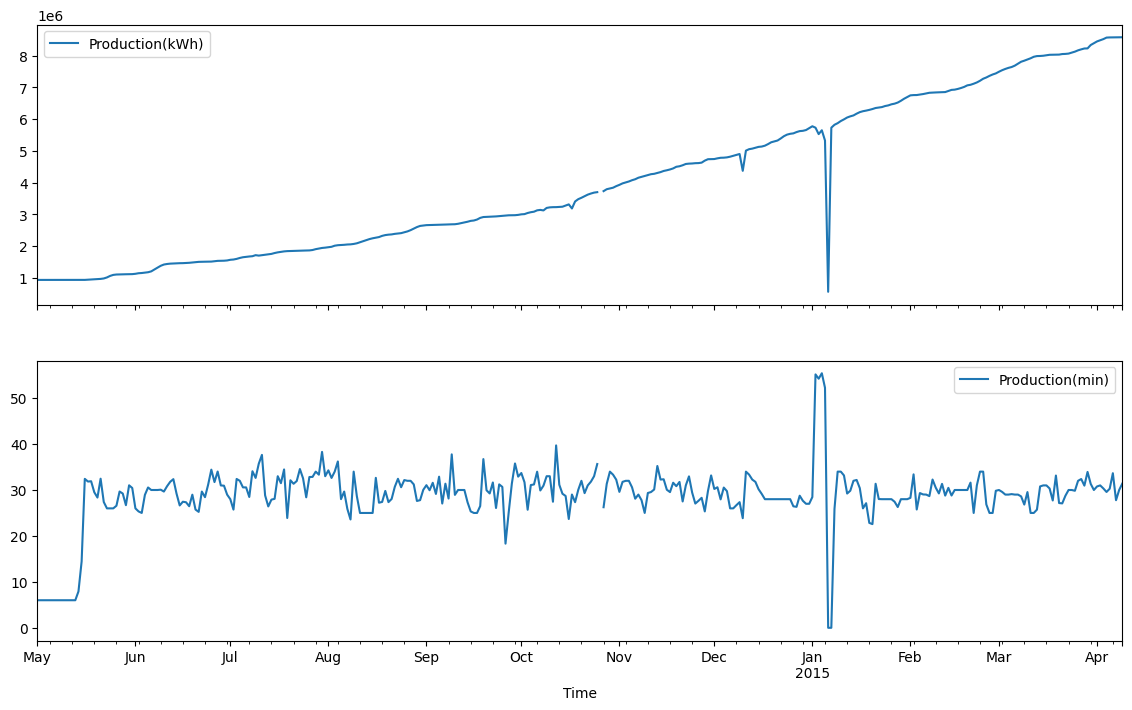

In [27]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(14, 8))
combined_data.resample('D').mean(numeric_only=True).plot(y="Production(kWh)", ax=axs[0])
combined_data.resample('D').mean(numeric_only=True).plot(y="Production(min)", ax=axs[1])

We see that there are fluctuations in the total energy (kWh) generated by the turbine, and these variations are attributed to instances of failures. The most prominent occurrence is noted at the beginning of January 2015. This pattern is visually evident in the production minutes plot.

### Energy/Power variation during faults

<Axes: xlabel='Fault', ylabel='Production(kWh)'>

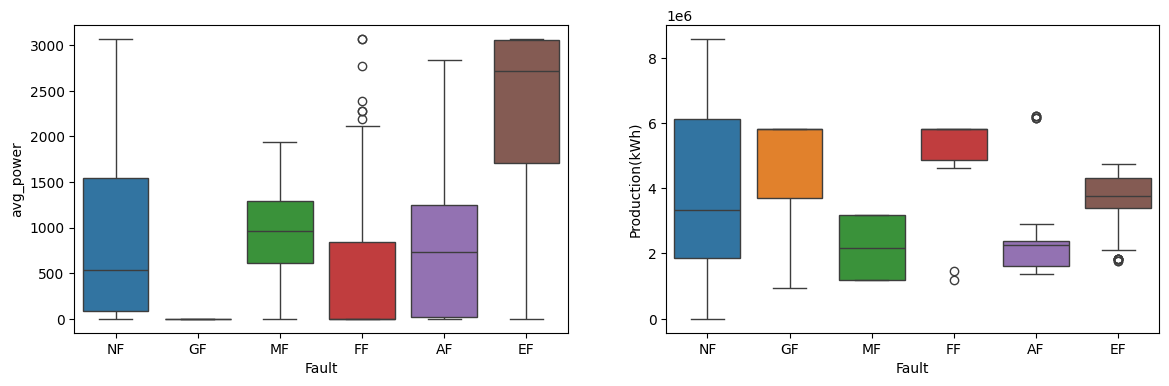

In [28]:
fig, axs = plt.subplots(1, 2, sharex='col', figsize=(14, 4))
sns.boxplot(data=combined_data, y="avg_power", x='Fault', hue='Fault', ax=axs[0])
sns.boxplot(data=combined_data, y="Production(kWh)", x='Fault', hue='Fault', ax=axs[1])

### Temperature features

Let's see the variation in the turbine components temperature during failure situations.

In [29]:
inverters_temperatures = combined_data[['temp_inverter11', 'temp_inverter12', 'temp_inverter13', 'temp_inverter14',
                         'temp_inverter15', 'temp_inverter16', 'temp_inverter17', 'temp_inverter21',
                         'temp_inverter22', 'temp_inverter23', 'temp_inverter24', 'temp_inverter25',
                         'temp_inverter26', 'temp_inverter27', 'Fault']]

In [30]:
invert_temp_by_fault = inverters_temperatures.groupby('Fault').mean().T
df = invert_temp_by_fault.copy()

# Compute temperature percentage change for fault cases compared to non fualt cases
changes_df = df.drop(columns="NF").subtract(df["NF"], axis=0)
temp_percentage_change = changes_df.div(df['NF'], axis=0) * 100
temp_percentage_change['NF'] = invert_temp_by_fault['NF']

Text(0.5, 1.0, 'Turbine inverters temperature change (%) during faults')

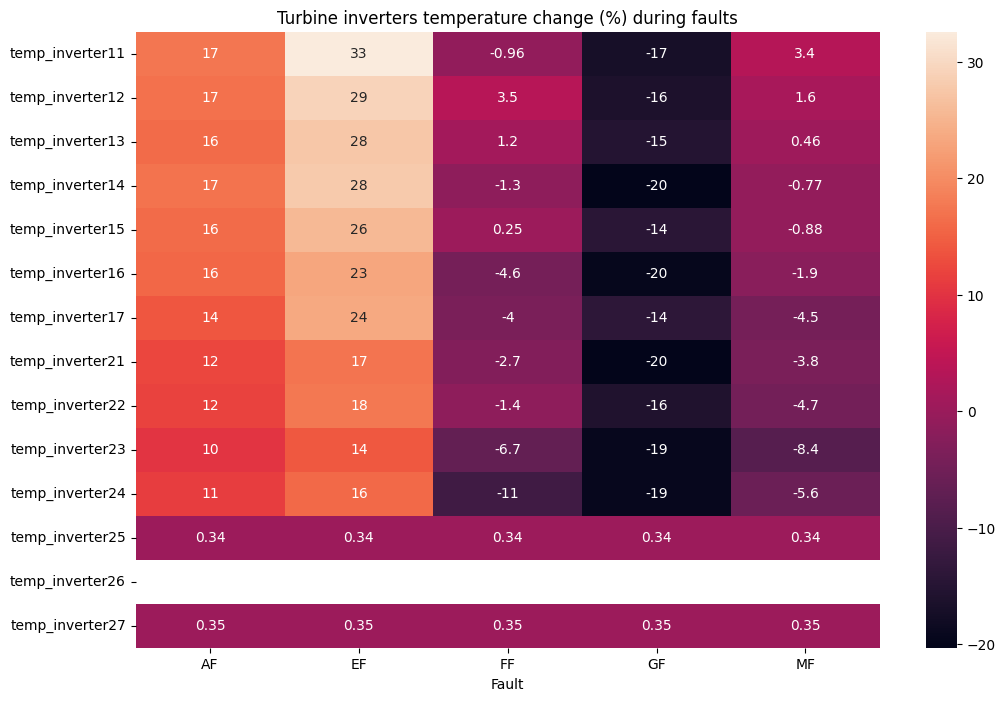

In [31]:
# plot inverters temperature percentage change during faults
plt.figure(figsize=(12, 8))
sns.heatmap(temp_percentage_change.iloc[:, :5], annot=True)
plt.title("Turbine inverters temperature change (%) during faults")

We find the following anomalies in from the inverters temperatures:

- **'AF' and 'EF' Faults:** In these cases, the inverter temperatures exhibit an increase of more than 10% compared to their normal values.

- **'GF' Faults:** During a 'GF' failure, all inverters experience a temperature drop ranging between 14% and 20%.

- **'FF' and 'MF' Faults:** For these faults, the inverter temperatures show a minor percentage change (1% to 10%), either an increase or decrease, depending on the specific inverter, in comparison to their nominal values.

- **Last Three Inverters:** These inverters appear to be operating outside their normal working range. Their temperatures, both nominal and during faults, deviate significantly from those of the other inverters in the system.

<Axes: >

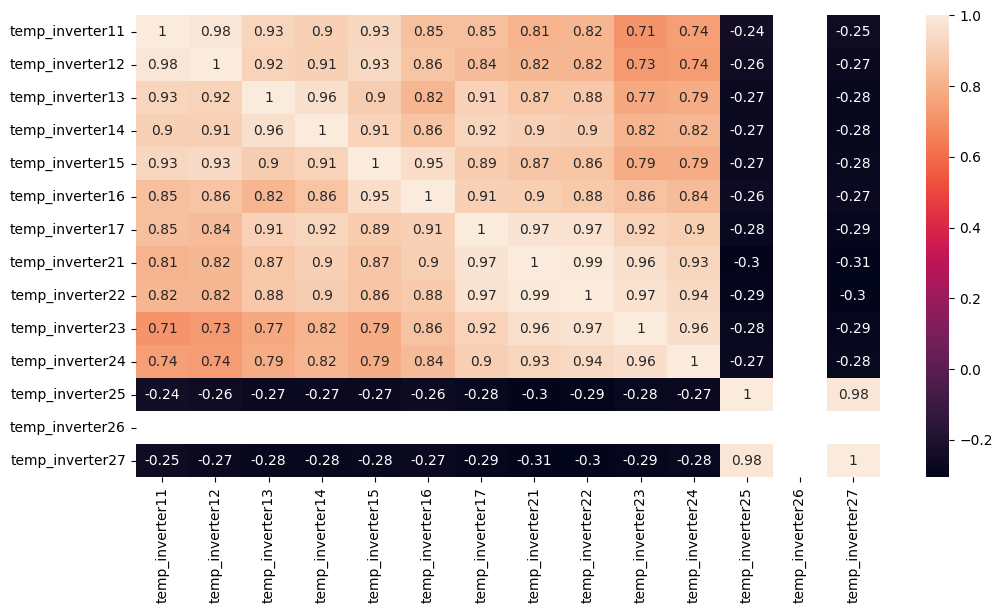

In [32]:
plt.figure(figsize=(12, 6))
sns.heatmap(inverters_temperatures.corr(numeric_only=True), annot=True)

We observe a high correlation among the temperature features of all inverters (excluding the last three inverters), we will consider dropping some of these features when training our models to avoid overfitting due to redundant informations.

In [33]:
# other turbine components temperatures
components_temp = combined_data[['temp_Spinner','temp_Front_bearing', 'temp_Rear_bearing', 'temp_Pitch_cabinet_blade_A',
                                   'temp_Pitch_cabinet_blade_B', 'temp_Pitch_cabinet_blade_C', 'temp_Blade_A', 'temp_Blade_B',
                                   'temp_Blade_C', 'temp_Rotor1', 'temp_Rotor2', 'temp_stator1', 'temp_stator2',
                                   'temp_nacelle_ambient1', 'temp_nacelle_ambient2','temp_nacelle', 'temp_nacelle_cabinet',
                                   'temp_main_carrier', 'temp_rectifier_cabinet', 'temp_yaw_inverter_cabinet',
                                   'temp_fan_inverter_cabinet', 'temp_ambient', 'temp_tower', 'temp_control_cabinet',
                                   'temp_Transformer', 'Fault']]

In [34]:
components_temp_by_fault = components_temp.groupby('Fault').mean().T
df = components_temp_by_fault.copy()

# Compute temperature percentage change for fault cases compared to non fualt cases
changes_df = df.drop(columns="NF").subtract(df["NF"], axis=0)
temp_percentage_change = changes_df.div(df['NF'], axis=0) * 100
temp_percentage_change['NF'] = components_temp_by_fault['NF']

Text(0.5, 1.0, 'Turbine components temperature change (%) during faults')

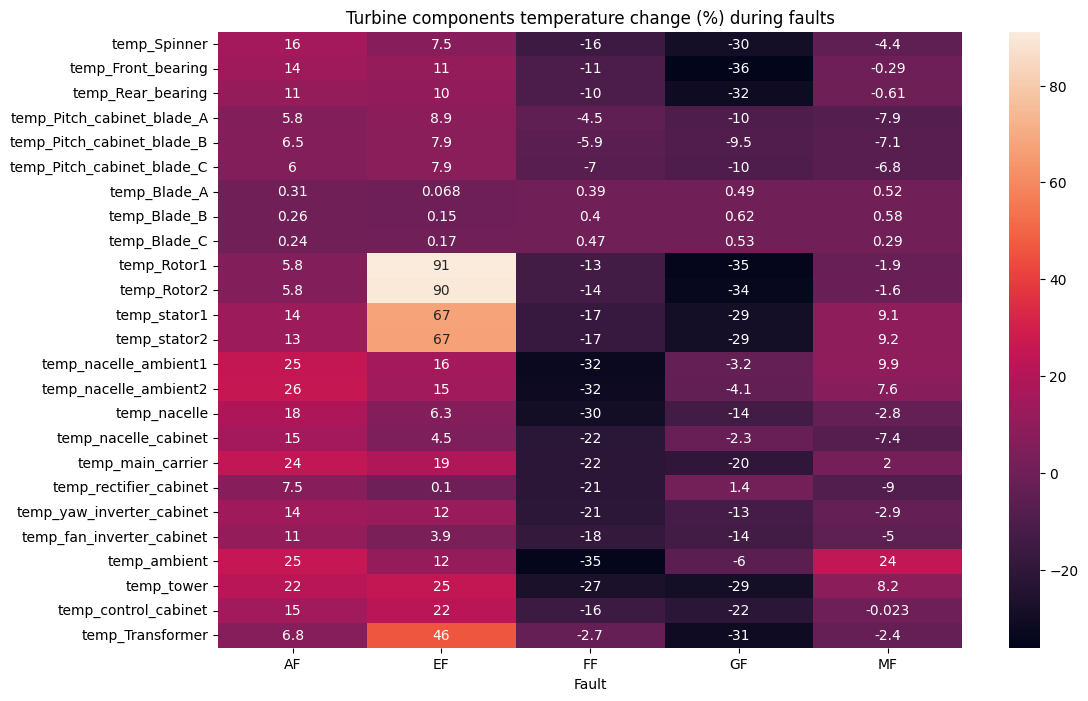

In [35]:
# plot components temperature percentage change during faults
plt.figure(figsize=(12, 8))
sns.heatmap(temp_percentage_change.iloc[:, :5], annot=True)
plt.title("Turbine components temperature change (%) during faults")

As wee did previously we can identify the following anomalies :

- In the presence of an AF fault, there is a noticeable surge in temperatures across all components, particularly in the nacelles, tower, and main carrier, with an increase exceeding 25%.

- In the event of an EF fault, substantial temperature elevations are observed in the rotors and stators (67% and 90%, respectively). Additionally, the transformer temperature experiences a 46% increase. Moreover, during these faults, inverter temperatures show a rise of more than 10% compared to their normal values.

- For FF and GF faults, there is a considerable decrease in component temperatures, exceeding -30%. In GF faults, notable temperature reductions are observed in the spinner, bearings, rotors, and stators, while a similar percentage drop is noted in the nacelles, tower, and rectifier.

- In the case of an MF fault, component temperatures exhibit either a minor increase or decrease, typically within the range of 2% to 10%.

- The temperatures of the A, B, C blades appear to remain unaffected during faults.

<Axes: >

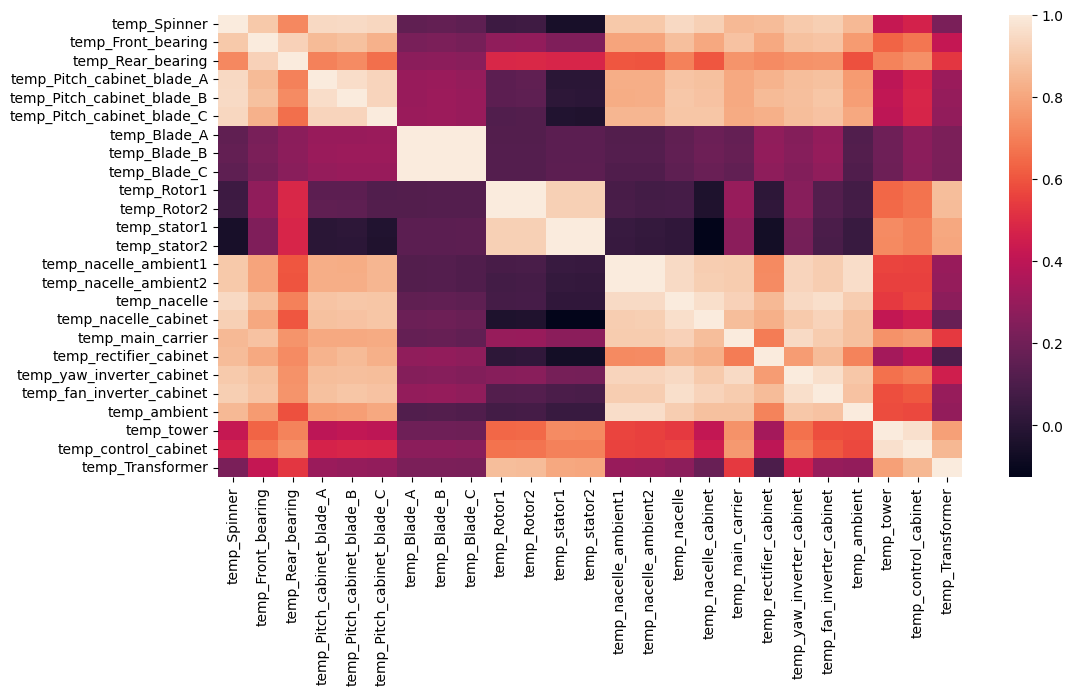

In [36]:
plt.figure(figsize=(12, 6))
sns.heatmap(components_temp.corr(numeric_only=True))

We see a high correlation among the temperature features of some components: the A,B,C blades temperatures, the rotors and stators tempeartures, the nacelles temperatures, we will consider dropping some of these features before training our models.

### Features Correlation

Let's remove the highly correlated features that we've found and see how the remaining correlate.

In [37]:
data = combined_data[['avg_ws', 'min_ws', 'avg_rot','min_rot', 'avg_power', 'avg_Nacel_position',
                      'Operating Hours', 'Production(kWh)', 'Production(min)', 'avg_reactive_power',
                      'max_reactive_power', 'min_reactive_power', 'avg_blade_angle_A', 'temp_inverter11',
                      'temp_inverter13', 'temp_inverter15', 'temp_inverter17', 'temp_inverter23',
                      'temp_inverter24', 'temp_Spinner','temp_Front_bearing', 'temp_Rear_bearing',
                      'temp_Pitch_cabinet_blade_A',  'temp_Blade_A', 'temp_Rotor1', 'temp_stator1',
                      'temp_nacelle_ambient1','temp_nacelle',  'temp_main_carrier', 'temp_rectifier_cabinet',
                      'temp_yaw_inverter_cabinet',  'temp_fan_inverter_cabinet', 'temp_ambient', 'temp_tower',
                      'temp_Transformer', 'avg_RTU_setpoint1', 'Inverter averages', 'Inverter std dev', 'Fault']]

<Axes: >

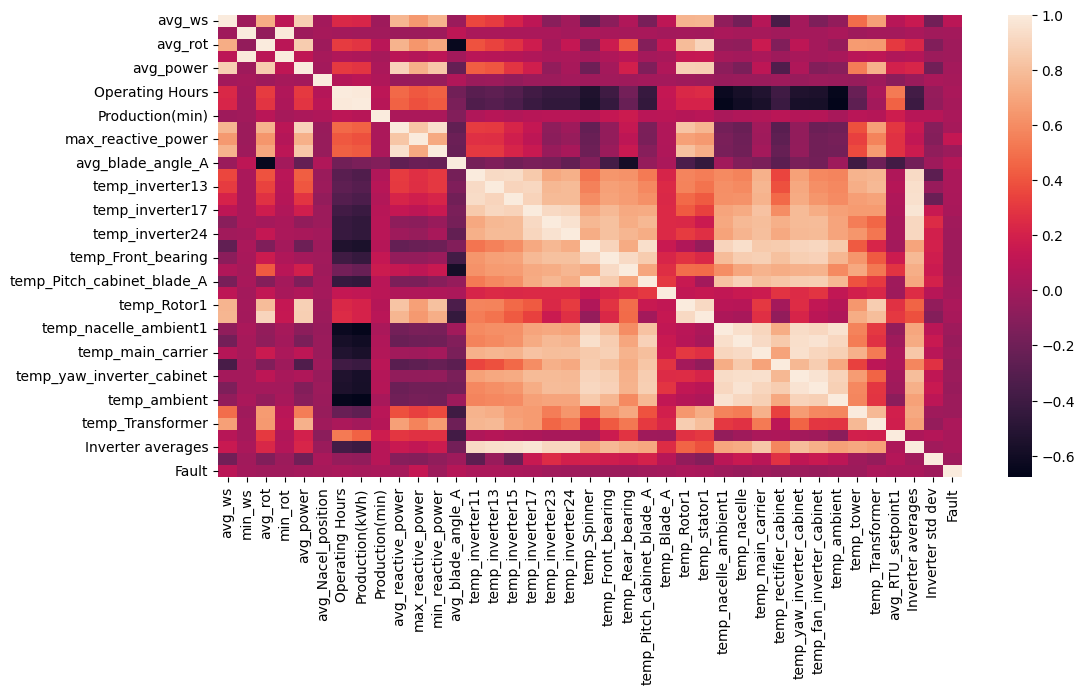

In [38]:
df = data.copy()
df["Fault"] = df["Fault"].map({"NF": 0, "AF": 1, "EF": 2, "FF": 3, "GF": 4, "MF": 5})

plt.figure(figsize=(12, 6))
sns.heatmap(df.corr())

Even though there are still some features that show high correlation, we'll try to train our models using this data and see what performance we can get.

## Data preprocessing

As we've seen our dataset is heavily imbalanced, so we must first take a smaller sample of the non faults instances and then try the models training.

In [39]:
df = data.copy()
df_with_faults = df[df.Fault != "NF"]
df_with_faults.shape

(446, 39)

In [40]:
df_no_faults = df[df.Fault == "NF"].sample(400, random_state=0)

In [41]:
df = pd.concat([df_no_faults, df_with_faults], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

In [42]:
target = df["Fault"]
X = df.drop(["Fault"], axis=1)

In [43]:
# we must first encode our fault classes into numerical values
encoder = LabelEncoder()
Y = encoder.fit_transform(target)

In [44]:
# Split the dataset: Training(80%), Testing(20%)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [45]:
# Scale features for models training
def scale_features(x_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train =  scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train, x_test

In [46]:
x_train, x_test = scale_features(x_train, x_test)

In [47]:
classes_labels = list(encoder.classes_)

# keep track of precision, recall scores
precision_scores = {}
recall_scores = {}

def plot_classification_result(model, y_test, y_pred):
    precision_scores[model] = np.round(np.array(precision_score(y_test, y_pred, average=None, zero_division=0)), 2)
    recall_scores[model] = np.round(np.array(recall_score(y_test, y_pred, average=None)), 2)
    print("Average accuracy score: ", accuracy_score(y_test, y_pred))
    print("Metrics table:\n", classification_report(y_test, y_pred, target_names=classes_labels, zero_division=0))
    print("Confusion matrix:\n")
    matrix = confusion_matrix(y_test, y_pred)
    matrix = pd.DataFrame(matrix, index=classes_labels, columns=classes_labels)
    plt.figure(figsize=(6, 4))
    plot = sns.heatmap(matrix, fmt='.2f', annot=True)
    plot.set_xlabel('Predicted')
    plot.set_ylabel('Real')

## Building ML models

### Logistic Regression Classifier

In [48]:
lrg_clf = LogisticRegression(multi_class='auto', max_iter=1000)
lrg_clf.fit(x_train, y_train)
y_pred = lrg_clf.predict(x_test)

Average accuracy score:  0.8588235294117647
Metrics table:
               precision    recall  f1-score   support

          AF       0.75      0.56      0.64        16
          EF       0.88      0.97      0.92        36
          FF       0.92      0.83      0.87        41
          GF       1.00      1.00      1.00        10
          MF       0.00      0.00      0.00         1
          NF       0.82      0.88      0.85        66

    accuracy                           0.86       170
   macro avg       0.73      0.71      0.71       170
weighted avg       0.85      0.86      0.85       170

Confusion matrix:



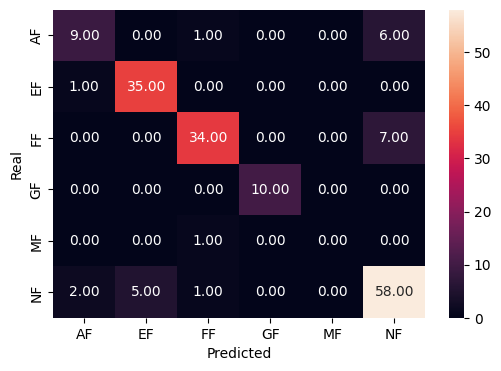

In [49]:
plot_classification_result("Logistic regression", y_test, y_pred)

#### Observation

The logistic regression model produced a good overall accuracy of 84%, but we see that it's struggle in the classification of the AF faults (only 57% f1 score). We also notice that the classifier is unable to learn about the MF fault and this due to the lack of instances (only 8) of this fault type, we need to considere the user of an oversample technique to fix that.

### Support Vector Machine

In [50]:
svc_clf = SVC()
svc_clf.fit(x_train, y_train)
y_pred = svc_clf.predict(x_test)

Average accuracy score:  0.8411764705882353
Metrics table:
               precision    recall  f1-score   support

          AF       0.55      0.38      0.44        16
          EF       0.85      0.97      0.91        36
          FF       0.97      0.88      0.92        41
          GF       1.00      1.00      1.00        10
          MF       0.00      0.00      0.00         1
          NF       0.79      0.85      0.82        66

    accuracy                           0.84       170
   macro avg       0.69      0.68      0.68       170
weighted avg       0.83      0.84      0.83       170

Confusion matrix:



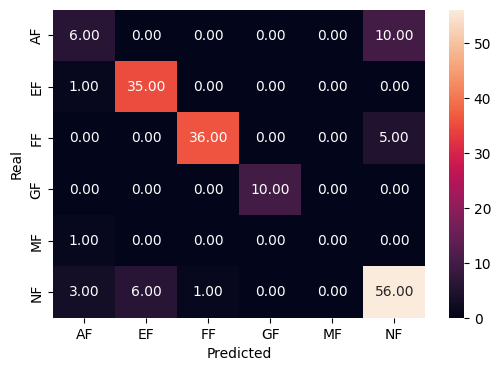

In [51]:
plot_classification_result("SVC", y_test, y_pred)

#### Observation

The SVC model gives a lower accuracy 82%, and struggle more in the classification of the AF faults with an f1 score of 43%. And as with the logistic regression model we notice that the SVC is unable to learn about the MF fault due to the smae reason.

### Decision Tree Classifier

In [52]:
tree_clf = DecisionTreeClassifier(random_state=1)
tree_clf.fit(x_train, y_train)
y_pred = tree_clf.predict(x_test)

Average accuracy score:  0.8705882352941177
Metrics table:
               precision    recall  f1-score   support

          AF       0.71      0.62      0.67        16
          EF       0.94      0.86      0.90        36
          FF       0.97      0.93      0.95        41
          GF       1.00      1.00      1.00        10
          MF       0.50      1.00      0.67         1
          NF       0.81      0.88      0.84        66

    accuracy                           0.87       170
   macro avg       0.82      0.88      0.84       170
weighted avg       0.88      0.87      0.87       170

Confusion matrix:



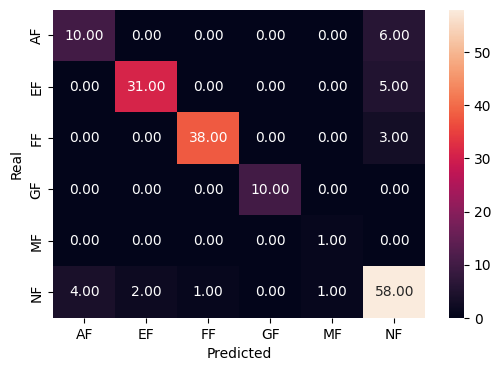

In [53]:
plot_classification_result("Decision tree", y_test, y_pred)

#### Observation

The decision tree model gives a higher overall accuracy of 86%, and it produce similair performance as the logistic regression model in the classification of the AF faults with an f1 score of 57%. Most importantly the model is able to classify the MF fault even with the lack of instances representing these class of failure.

### Random Forest Classifier

In [54]:
rf_clf = RandomForestClassifier(n_estimators=200, random_state=1)
rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)

Average accuracy score:  0.9117647058823529
Metrics table:
               precision    recall  f1-score   support

          AF       0.77      0.62      0.69        16
          EF       0.94      0.92      0.93        36
          FF       0.98      0.98      0.98        41
          GF       1.00      1.00      1.00        10
          MF       0.00      0.00      0.00         1
          NF       0.87      0.94      0.91        66

    accuracy                           0.91       170
   macro avg       0.76      0.74      0.75       170
weighted avg       0.91      0.91      0.91       170

Confusion matrix:



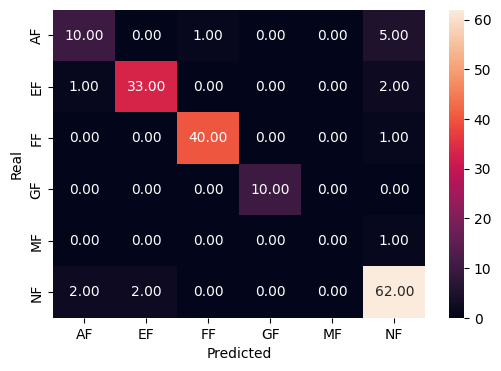

In [55]:
plot_classification_result("Random forest", y_test, y_pred)

#### Observation

The Random Forest model produced the highest accuracy score so far 93%, it gives good F1 scores across all fault classes, but the model is not able to classify the MF fault at all.

### XGBoost Classifier

In [56]:
xgb_clf = XGBClassifier(n_estimators=200, random_state=1)
xgb_clf.fit(x_train, y_train)
y_pred = xgb_clf.predict(x_test)

Average accuracy score:  0.9294117647058824
Metrics table:
               precision    recall  f1-score   support

          AF       0.85      0.69      0.76        16
          EF       0.94      0.94      0.94        36
          FF       1.00      0.98      0.99        41
          GF       1.00      1.00      1.00        10
          MF       1.00      1.00      1.00         1
          NF       0.89      0.94      0.91        66

    accuracy                           0.93       170
   macro avg       0.95      0.92      0.93       170
weighted avg       0.93      0.93      0.93       170

Confusion matrix:



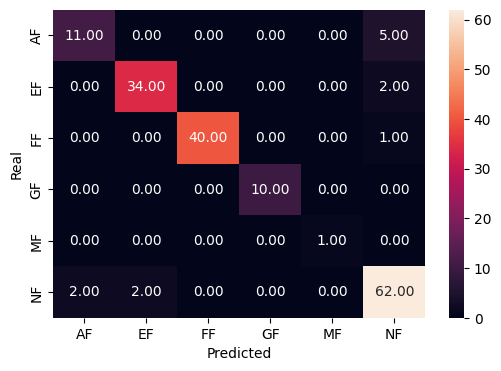

In [57]:
plot_classification_result("XGBoost", y_test, y_pred)

#### Observation

The XGBoost model has a lower overall accuracy 91% compared with random forest, it gives relatively good F1 scores across all fault classes except for the MF fault class which is not classified at all by the model.

### Results analysis

#### Models Precision results

In [58]:
precision_results = pd.DataFrame(precision_scores, index=classes_labels)
precision_results.T

,AF,EF,FF,GF,MF,NF
Logistic regression,0.75,0.88,0.92,1.0,0.0,0.82
SVC,0.55,0.85,0.97,1.0,0.0,0.79
Decision tree,0.71,0.94,0.97,1.0,0.5,0.81
Random forest,0.77,0.94,0.98,1.0,0.0,0.87
XGBoost,0.85,0.94,1.00,1.0,1.0,0.89


#### Models Recall results

In [59]:
recall_results = pd.DataFrame(recall_scores, index=classes_labels)
recall_results.T

,AF,EF,FF,GF,MF,NF
Logistic regression,0.56,0.97,0.83,1.0,0.0,0.88
SVC,0.38,0.97,0.88,1.0,0.0,0.85
Decision tree,0.62,0.86,0.93,1.0,1.0,0.88
Random forest,0.62,0.92,0.98,1.0,0.0,0.94
XGBoost,0.69,0.94,0.98,1.0,1.0,0.94


#### Observation

* All the models produced good overall accuracy results surpassing 82%, and the radom forest was the model that gave the highest accuracy result 93%.

* The decision tree was the only model that was able to classify the MF fault class, while other models were unable to learn about this fault type due to the lack of its representation in our data, we must considere using an oversampling technique here to fix this.